1.什么时候分negative 和 positive？
2.什么时候处理imbalance dataset
3.什么时候画word cloud

Imbalance
Ensemble Method
CV - overfitting?
Tune model (GridSearchCV)

deal with 


github的code，tf idf，最后看最多的word cloud
然后用weight调一下模型

lg
lg+weight
SVM



更新：
画一下negative 和 positive的word cloud
lg
lg + weight
SVM + weight

看是否overfit
然后
拿最好的模型tune model


tip做test data，然后计算餐厅的平均sentiment分数




记得按照这个流程整理一下notebook
https://towardsdatascience.com/first-time-machine-learning-model-with-pyspark-3684cf406f54

In [ ]:
import sparknlp
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [ ]:
#create Spark session
spark = SparkSession.builder.appName('YelpML').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [ ]:
# Import Data
dataDir = "gs://msca-bdp-student-gcs/group2/yelp-datasample2"
business = spark.read.json(dataDir + "/sample_business")
review = spark.read.json(dataDir + "/sample_review")
tip = spark.read.json(dataDir + "/sample_tip")

23/08/14 00:46:44 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Overview

### Join review df and business df to find the category information for all kinds of businesses

In [ ]:
review.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|arKiXax3ScSM_z3O-...|   0|2010-10-17 01:50:46|    0|zCNdcNrkIKefTPbak...|  5.0|Great Italian foo...|     0|bz2FrqfKrVmS7WwC-...|
|aeFXIzYpWjSdtq5w8...|   3|2013-06-29 13:42:57|    0|aweHR8S6QAEuV4hoH...|  3.0|I have heard many...|     4|CAU7F-vDqbQZ67BBY...|
|rAytSQU5RQHvXe1Wl...|   1|2021-02-03 21:32:58|    0|CefnkUvmbiDsexuxz...|  5.0|I wish this locat...|     2|BHcPaG4X220bQsqOR...|
|uFLqtC7Yq03dDrxU0...|   2|2013-02-09 13:23:26|    2|geSJqq4MUPos2l8ZI...|  4.0|Why I like Smooth...|     7|DAeC-Y66n-jNMJJw4...|
|3u1cP7H4g325tkhNE...|   0|2021-01-02 17:01:16|    0|P0gEHckZurgPi7_7f...|  5.0|I rarely g

In [ ]:
review.count()

70241

In [ ]:
review = review.select('business_id', 'text', 'stars')

In [ ]:
review.show(5)

+--------------------+--------------------+-----+
|         business_id|                text|stars|
+--------------------+--------------------+-----+
|arKiXax3ScSM_z3O-...|Great Italian foo...|  5.0|
|aeFXIzYpWjSdtq5w8...|I have heard many...|  3.0|
|rAytSQU5RQHvXe1Wl...|I wish this locat...|  5.0|
|uFLqtC7Yq03dDrxU0...|Why I like Smooth...|  4.0|
|3u1cP7H4g325tkhNE...|I rarely go to a ...|  5.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
business.show(5)

+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|            address|          attributes|         business_id|          categories|               city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|      2141 Caton St|{null, null, null...|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|        New Orleans|{0:0-0:0, 0:0-0:0...|      1|   29.9991154|   -90.0607732|     Anytime Fitness|      70122|           6|  3.0|   LA|
|5413 Neshaminy Blvd|{null, null, u'no...|p184f-Zvf4ToPwLba...|Chinese, Restaura...|           Bensalem|{11:30-23:0,

In [ ]:
business = business.select('business_id', 'categories')

In [ ]:
business.show(5)

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|
|p184f-Zvf4ToPwLba...|Chinese, Restaura...|
|cl5NjtALgaX7E-WL2...|Food, Wholesalers...|
|Q-a-DzqRufrPL6EcU...|Beer, Wine & Spir...|
|isbeaPln-E0DdffLR...|Specialty Food, M...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import explode, split
business = business.withColumn('categories_split', explode(split('categories', ', ')))

In [ ]:
business.show()

+--------------------+--------------------+--------------------+
|         business_id|          categories|    categories_split|
+--------------------+--------------------+--------------------+
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|Fitness & Instruc...|
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|                Gyms|
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...| Weight Loss Centers|
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|    Health & Medical|
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|            Trainers|
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|         Active Life|
|p184f-Zvf4ToPwLba...|Chinese, Restaura...|             Chinese|
|p184f-Zvf4ToPwLba...|Chinese, Restaura...|         Restaurants|
|p184f-Zvf4ToPwLba...|Chinese, Restaura...|            Japanese|
|cl5NjtALgaX7E-WL2...|Food, Wholesalers...|                Food|
|cl5NjtALgaX7E-WL2...|Food, Wholesalers...|         Wholesalers|
|cl5NjtALgaX7E-WL2...|Food, Wholesalers...|   Coffee Roasteries|
|cl5NjtALgaX7E-WL2...|Foo

### Choose the reviews of restaurant category for furthur analysis

In [ ]:
from pyspark.sql.functions import col
business = business.where(col('categories_split') == 'Restaurants').select('business_id', 'categories_split')

In [ ]:
df = review.join(business, on = 'business_id', how = 'inner')

In [ ]:
df.show(5)

+--------------------+--------------------+-----+----------------+
|         business_id|                text|stars|categories_split|
+--------------------+--------------------+-----+----------------+
|PWGcA2s9sf4iMb4dc...|I have been eatin...|  5.0|     Restaurants|
|Fbtcj6j9-byxq68AC...|My mom and I love...|  5.0|     Restaurants|
|SKcKQOqjMCUYsQHuJ...|Wine was original...|  1.0|     Restaurants|
|yR_EfNX8NF_JQTo2L...|I'm Italian Ameri...|  5.0|     Restaurants|
|2rOBCDR32E8GXAya7...|Because I go to t...|  4.0|     Restaurants|
+--------------------+--------------------+-----+----------------+
only showing top 5 rows



In [ ]:
df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- categories_split: string (nullable = true)



In [ ]:
df.count()

385

In [ ]:
df = df.repartition(16)

### Data Exploration

In [ ]:
df1 = df.groupBy('stars').count().orderBy('stars', ascending = [1])

In [ ]:
df1.show()

+-----+-----+
|stars|count|
+-----+-----+
|  1.0|   53|
|  2.0|   35|
|  3.0|   54|
|  4.0|   73|
|  5.0|  170|
+-----+-----+



In [ ]:
pdf1 = df1.toPandas()

<AxesSubplot:xlabel='stars'>

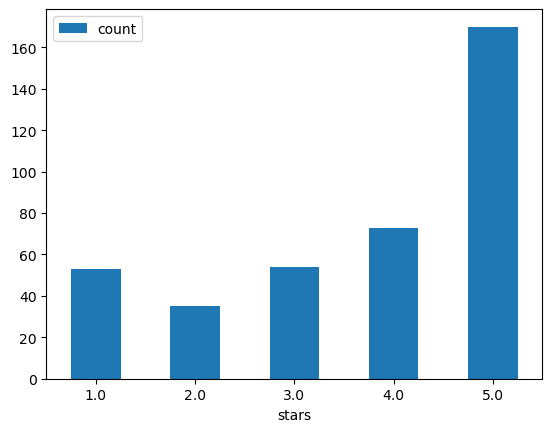

In [ ]:
pdf1.plot(kind = 'bar', x = 'stars', y = 'count', rot = 360)

We have observed a trend where 5-star reviews receive the highest level of popularity. Additionally, we've noticed that 1-star reviews are more frequent compared to reviews with 2 or 3 stars. It can be assumed that customers are more inclined to go through the effort of writing a review when they are either extremely satisfied or extremely dissatisfied.

The stars are then relabelled so that any reviews with 4 stars or above will be positive, anything else is deemed to be negative. This benchmark is based on a general consensus about Yelp reviews where people tend to overrate restaurants/businesses unless they feel strongly negatively about the place. 

In [ ]:
from pyspark.sql.functions import when
df = df.withColumn("label", when(df.stars >= 4, 1).otherwise(0))

In [ ]:
df.show(5)

+--------------------+--------------------+-----+----------------+-----+
|         business_id|                text|stars|categories_split|label|
+--------------------+--------------------+-----+----------------+-----+
|RyndNvh5DEsywX76c...|This was a very s...|  4.0|     Restaurants|    1|
|YFZEUO2lipPqQdWGq...|This place is ser...|  1.0|     Restaurants|    0|
|wlORwhEzCTEHari93...|This place is awe...|  4.0|     Restaurants|    1|
|5E7Zk3g6kLsB72J4E...|I met a friend at...|  4.0|     Restaurants|    1|
|B-DiQpcSTJ7oMMnwz...|Heard about this ...|  4.0|     Restaurants|    1|
+--------------------+--------------------+-----+----------------+-----+
only showing top 5 rows



In [ ]:
df2 = df.groupBy('label').count().orderBy('count', ascending = [1])

In [ ]:
df2.show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  142|
|    1|  243|
+-----+-----+



In [ ]:
pdf2 = df2.toPandas()

<AxesSubplot:xlabel='label'>

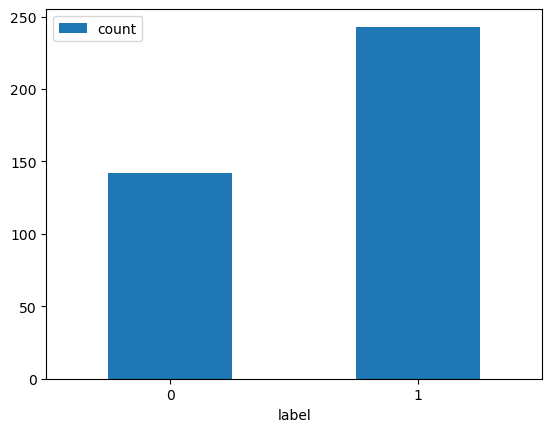

In [ ]:
pdf2.plot(kind = 'bar', x = 'label', y = 'count', rot = 360)

In [ ]:
df = df.select('text', 'label')

In [ ]:
df.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|I've been a loyal...|    0|
|Checked this plac...|    0|
|Is this place clo...|    0|
|We are so excited...|    1|
|I moved to Nashvi...|    1|
+--------------------+-----+
only showing top 5 rows



In [ ]:
res_categories = res.select('categories').collect()
res_categories = [res_categories[i][0] for i in range(len(res_categories))]
text = " ".join(i for i in res_categories)
#pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# eliminate useless words
text = text.replace('Restaurants', "")
text = text.replace('Bars', "")
text = text.replace('Food', "")

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

NameError: name 'res' is not defined

## Text Preprocessing

In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import Word2Vec

In [ ]:
# Initialize SparkNLP components
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

languageDetector = LanguageDetectorDL.pretrained() \
    .setInputCols("document") \
    .setOutputCol("language")

# Create a SparkNLP pipeline
pipeline1 = Pipeline(stages=[document_assembler, languageDetector])

ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[OK!]


### Detect review languages

In [ ]:
df_lang = pipeline1.fit(df).transform(df)
df_lang = df_lang.select("text", "label", "language.result")

In [ ]:
df_lang.show(10)

+--------------------+-----+------+
|                text|label|result|
+--------------------+-----+------+
|I've been a loyal...|    0|  [en]|
|Checked this plac...|    0|  [en]|
|Is this place clo...|    0|  [en]|
|We are so excited...|    1|  [en]|
|I moved to Nashvi...|    1|  [en]|
|If you like 90% b...|    1|  [en]|
|I saw this place ...|    0|  [en]|
|It's Mexican fast...|    1|  [en]|
|Farotto's - you d...|    0|  [en]|
|I love this place...|    1|  [en]|
+--------------------+-----+------+
only showing top 10 rows



In [ ]:
df_lang.printSchema()

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- result: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
df3 = df_lang.groupBy('result').count().orderBy('count', ascending = [0])

In [ ]:
df3.show()

In [ ]:
pdf3 = df3.toPandas()

<AxesSubplot:ylabel='result'>

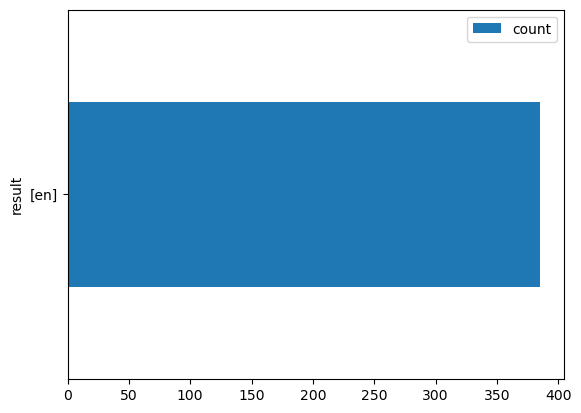

In [ ]:
pdf3.plot(kind = 'barh', x = 'result', y = 'count')

In [ ]:
from pyspark.sql.functions import array_contains

# Only keep the reviews written in English for future analysis
df_lang = df_lang.filter(array_contains(col("result"), "en"))

In [ ]:
df_lang.show(5)

In [ ]:
df_lang = df_lang.drop('result')

### Produce a final processed output

In [ ]:
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True) \
    .setCleanupPatterns(["""[^\w\d\s]"""])

lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(["normalized"]) \
    .setOutputCol("lemmatized")

finisher = Finisher() \
    .setInputCols(['lemmatized']) \
    .setOutputCols(["finished"])

word2vec = Word2Vec(vectorSize=100) \
    .setInputCol("finished") \
    .setOutputCol("features")

pipeline2 = Pipeline(stages=[document_assembler, tokenizer, normalizer, lemmatizer, finisher, word2vec])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[OK!]


In [ ]:
pipeline_model = pipeline2.fit(df_lang)
encodedData = pipeline_model.transform(df_lang)

In [ ]:
encodedData = encodedData.select('text', 'label', 'features')

In [ ]:
encodedData.show(5)

+--------------------+-----+--------------------+
|                text|label|            features|
+--------------------+-----+--------------------+
|I've been a loyal...|    0|[-0.0010186109519...|
|Checked this plac...|    0|[0.01366819298181...|
|Is this place clo...|    0|[0.00616920861228...|
|We are so excited...|    1|[0.01051794498094...|
|I moved to Nashvi...|    1|[0.01144787097596...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [ ]:
encodedData.cache()

DataFrame[text: string, label: int, features: vector]

## Classification Models

In [ ]:
#spark ML imports
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [ ]:
#split data into train and test
train_df, test_df = encodedData.randomSplit([.8,.2],seed = 16)
train_df.show(5)

+--------------------+-----+--------------------+
|                text|label|            features|
+--------------------+-----+--------------------+
|Checked this plac...|    0|[0.01366819298181...|
|Farotto's - you d...|    0|[4.34597884551203...|
|Food is great, bu...|    0|[-0.0030196412569...|
|Food was amazing!...|    1|[0.01513816136866...|
|Four stars becaus...|    1|[0.00721082088971...|
+--------------------+-----+--------------------+
only showing top 5 rows



### Elastic Net Logistic Regression

In [ ]:
lambda_par = 0.02
alpha_par = 0.3
lr = LogisticRegression().\
        setLabelCol('label').\
        setFeaturesCol('features').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

In [ ]:
lrModel = lr.fit(train_df)
lr_pred = lrModel.transform(test_df)
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
lr_f1 = f1_eval.evaluate(lr_pred)
print("F1 score: %.4f" % lr_f1)

F1 score: 0.7272


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print("accuracy:", round(evaluator.evaluate(lr_pred, {evaluator.metricName: "accuracy"}), 2))
print("f1:", round(evaluator.evaluate(lr_pred, {evaluator.metricName: "f1"}), 2))

accuracy: 0.75
f1: 0.73


In [1]:
import sparknlp
import pandas as pd
sparknlp.start()

from sparknlp.base import *
from sparknlp.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
#create Spark session
spark = SparkSession.builder.appName('YelpML').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [3]:
# Import Data
dataDir = "gs://msca-bdp-student-gcs/group2/yelp-datasample2"
business = spark.read.json(dataDir + "/sample_business")
review = spark.read.json(dataDir + "/sample_review")

23/08/13 00:36:12 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Overview

### Join review df and business df to find the category information for all kinds of businesses

In [4]:
review.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|arKiXax3ScSM_z3O-...|   0|2010-10-17 01:50:46|    0|zCNdcNrkIKefTPbak...|  5.0|Great Italian foo...|     0|bz2FrqfKrVmS7WwC-...|
|aeFXIzYpWjSdtq5w8...|   3|2013-06-29 13:42:57|    0|aweHR8S6QAEuV4hoH...|  3.0|I have heard many...|     4|CAU7F-vDqbQZ67BBY...|
|rAytSQU5RQHvXe1Wl...|   1|2021-02-03 21:32:58|    0|CefnkUvmbiDsexuxz...|  5.0|I wish this locat...|     2|BHcPaG4X220bQsqOR...|
|uFLqtC7Yq03dDrxU0...|   2|2013-02-09 13:23:26|    2|geSJqq4MUPos2l8ZI...|  4.0|Why I like Smooth...|     7|DAeC-Y66n-jNMJJw4...|
|3u1cP7H4g325tkhNE...|   0|2021-01-02 17:01:16|    0|P0gEHckZurgPi7_7f...|  5.0|I rarely g

In [5]:
review.count()

70241

In [6]:
review = review.select('business_id', 'text', 'stars')

In [7]:
review.show(5)

+--------------------+--------------------+-----+
|         business_id|                text|stars|
+--------------------+--------------------+-----+
|arKiXax3ScSM_z3O-...|Great Italian foo...|  5.0|
|aeFXIzYpWjSdtq5w8...|I have heard many...|  3.0|
|rAytSQU5RQHvXe1Wl...|I wish this locat...|  5.0|
|uFLqtC7Yq03dDrxU0...|Why I like Smooth...|  4.0|
|3u1cP7H4g325tkhNE...|I rarely go to a ...|  5.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [8]:
business.show(5)

+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|            address|          attributes|         business_id|          categories|               city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|      2141 Caton St|{null, null, null...|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|        New Orleans|{0:0-0:0, 0:0-0:0...|      1|   29.9991154|   -90.0607732|     Anytime Fitness|      70122|           6|  3.0|   LA|
|5413 Neshaminy Blvd|{null, null, u'no...|p184f-Zvf4ToPwLba...|Chinese, Restaura...|           Bensalem|{11:30-23:0,

In [9]:
business = business.select('business_id', 'categories')

In [10]:
business.show(5)

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|
|p184f-Zvf4ToPwLba...|Chinese, Restaura...|
|cl5NjtALgaX7E-WL2...|Food, Wholesalers...|
|Q-a-DzqRufrPL6EcU...|Beer, Wine & Spir...|
|isbeaPln-E0DdffLR...|Specialty Food, M...|
+--------------------+--------------------+
only showing top 5 rows



In [11]:
from pyspark.sql.functions import explode, split
business = business.withColumn('categories_split', explode(split('categories', ', ')))

In [12]:
business.show()

+--------------------+--------------------+--------------------+
|         business_id|          categories|    categories_split|
+--------------------+--------------------+--------------------+
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|Fitness & Instruc...|
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|                Gyms|
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...| Weight Loss Centers|
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|    Health & Medical|
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|            Trainers|
|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|         Active Life|
|p184f-Zvf4ToPwLba...|Chinese, Restaura...|             Chinese|
|p184f-Zvf4ToPwLba...|Chinese, Restaura...|         Restaurants|
|p184f-Zvf4ToPwLba...|Chinese, Restaura...|            Japanese|
|cl5NjtALgaX7E-WL2...|Food, Wholesalers...|                Food|
|cl5NjtALgaX7E-WL2...|Food, Wholesalers...|         Wholesalers|
|cl5NjtALgaX7E-WL2...|Food, Wholesalers...|   Coffee Roasteries|
|cl5NjtALgaX7E-WL2...|Foo

### Choose the reviews of restaurant category for furthur analysis

In [13]:
from pyspark.sql.functions import col
business = business.where(col('categories_split') == 'Restaurants').select('business_id', 'categories_split')

In [14]:
df = review.join(business, on = 'business_id', how = 'inner')

In [15]:
df.show(5)

+--------------------+--------------------+-----+----------------+
|         business_id|                text|stars|categories_split|
+--------------------+--------------------+-----+----------------+
|PWGcA2s9sf4iMb4dc...|I have been eatin...|  5.0|     Restaurants|
|Fbtcj6j9-byxq68AC...|My mom and I love...|  5.0|     Restaurants|
|SKcKQOqjMCUYsQHuJ...|Wine was original...|  1.0|     Restaurants|
|yR_EfNX8NF_JQTo2L...|I'm Italian Ameri...|  5.0|     Restaurants|
|2rOBCDR32E8GXAya7...|Because I go to t...|  4.0|     Restaurants|
+--------------------+--------------------+-----+----------------+
only showing top 5 rows



In [16]:
df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- categories_split: string (nullable = true)



In [17]:
df.count()

385

In [18]:
df = df.repartition(16)

### Review EDA

In [19]:
df1 = df.groupBy('stars').count().orderBy('stars', ascending = [1])

In [20]:
df1.show()

+-----+-----+
|stars|count|
+-----+-----+
|  1.0|   53|
|  2.0|   35|
|  3.0|   54|
|  4.0|   73|
|  5.0|  170|
+-----+-----+



In [21]:
pdf = df1.toPandas()

<AxesSubplot:xlabel='stars'>

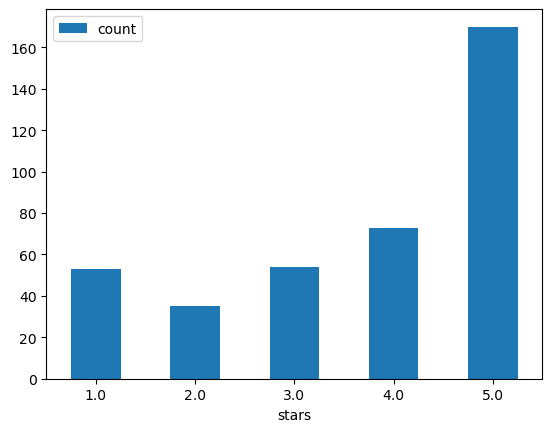

In [22]:
pdf.plot(kind = 'bar', x = 'stars', y = 'count', rot = 360)

We have observed a trend where 5-star reviews receive the highest level of popularity. Additionally, we've noticed that 1-star reviews are more frequent compared to reviews with 2 or 3 stars. It can be assumed that customers are more inclined to go through the effort of writing a review when they are either extremely satisfied or extremely dissatisfied.

## Data Preprocessing

In [23]:
# Detect the language of text and only keep English

In [28]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[OK!]


In [41]:
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

languageDetector = LanguageDetectorDL.pretrained() \
    .setInputCols("document") \
    .setOutputCol("language")

pipeline = Pipeline() \
    .setStages([
      documentAssembler,
      languageDetector
    ])

ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[OK!]


In [34]:
df = pipeline.fit(df).transform(df)
df = df.select("business_id", "text", "stars", "categories_split", "document", "language.result")

In [35]:
df.show()

+--------------------+--------------------+-----+----------------+--------------------+------+
|         business_id|                text|stars|categories_split|            document|result|
+--------------------+--------------------+-----+----------------+--------------------+------+
|RyndNvh5DEsywX76c...|This was a very s...|  4.0|     Restaurants|[{document, 0, 31...|  [en]|
|YFZEUO2lipPqQdWGq...|This place is ser...|  1.0|     Restaurants|[{document, 0, 43...|  [en]|
|wlORwhEzCTEHari93...|This place is awe...|  4.0|     Restaurants|[{document, 0, 11...|  [en]|
|5E7Zk3g6kLsB72J4E...|I met a friend at...|  4.0|     Restaurants|[{document, 0, 93...|  [en]|
|B-DiQpcSTJ7oMMnwz...|Heard about this ...|  4.0|     Restaurants|[{document, 0, 70...|  [en]|
|BgFNEv82LTITXahqY...|I ate here the ot...|  1.0|     Restaurants|[{document, 0, 37...|  [en]|
|EfXTQPiVBym_2KoG7...|You will have to ...|  5.0|     Restaurants|[{document, 0, 81...|  [en]|
|q_PFmdGcKx2H7z2ze...|Exceptional varie...|  4.0| 

In [36]:
df2 = df.groupBy('result').count().orderBy('count', ascending = [0])

In [37]:
df2.show()

+------+-----+
|result|count|
+------+-----+
|  [en]|  385|
+------+-----+



In [ ]:
#https://sparknlp.org/2020/12/05/detect_language_21_xx.html
from sparknlp.pretrained import PretrainedPipeline
pipeline = PretrainedPipeline("detect_language_21", lang = "xx")

In [ ]:
# Define a UDF using the F.udf function
def detect_language_udf(text):
    result = pipeline.annotate(text)
    return result['language'][0] if result and 'language' in result else None

detect_language_spark_udf = F.udf(detect_language_udf, StringType())

# Apply the UDF to the 'text' column and create a new column 'detected_language'
df_with_language = df.withColumn("detected_language", detect_language_spark_udf(df["text"]))

# Show the resulting DataFrame with detected languages
df_with_language.show(truncate=False)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def detect_language(text):
    result = pipeline.annotate(text)
    return result['language'][1]

detect_language_udf = udf(detect_language, StringType())

In [ ]:
def detect_language_udf(text_series: pd.Series) -> pd.Series:
    result = []
    for text in text_series:
        annotations = pipeline.annotate(text)
        result.append(annotations['language'][0])
    return pd.Series(result)

In [ ]:
df = df.withColumn('language', detect_language_udf(df['text']))

In [ ]:
review.count()

In [ ]:
review = review.repartition(16)

In [ ]:
review.rdd.getNumPartitions()

In [ ]:
review_sample = review.sample(fraction=0.02, seed=42)

In [ ]:
review_sample.count()

In [ ]:
review_sample.show()

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Word2Vec
from pyspark.ml.regression import LinearRegression
# from sparknlp.base import DocumentAssembler, Finisher
# from sparknlp.annotator import Tokenizer, Normalizer

In [ ]:
review_sample = review_sample.select('text', 'stars')

## Preprocessing

Includes: tokenizer, normalizer, and lemmatizer

In [ ]:
# Initialize SparkNLP components
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normalized").setLowercase(True) \
    .setCleanupPatterns(["""[^\w\d\s]"""])
lemmatizer = LemmatizerModel.pretrained().setInputCols(["normalized"]).setOutputCol("lemmatized")
finisher = Finisher().setInputCols(['lemmatized']).setOutputCols(["finished"])

# Create a SparkNLP pipeline
pipeline = Pipeline(stages=[document_assembler, tokenizer, normalizer, lemmatizer, finisher])



# Fit and transform the data
processed_data = pipeline.fit(review_sample).transform(review_sample)

# processed_data = processed_data.withColumn("normalized_tokens", F.expr("transform(normalized, x -> x.result)"))

In [ ]:
processed_data = processed_data.drop('text')

In [ ]:
processed_data.show()

In [ ]:
# Use Word2Vec to convert text into dense vectors
word2vec = Word2Vec(vectorSize=100, inputCol="finished", outputCol="features")
word2vec_model = word2vec.fit(processed_data)
word2vec_data = word2vec_model.transform(processed_data)

# Split the data into training and test sets
(training_data, test_data) = word2vec_data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Initialize and train the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="stars")
lr_model = lr.fit(training_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model (optional)
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="stars", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

In [ ]:
user.count()